# Photon ID Run 2 BDT working point optimization

In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

In [3]:
df = pd.read_pickle(datadir+"df_test_sample_hard_scattering_skim30.pkl")
df.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,y_truth_pt,y_truth_eta,Original_background_score,Original_signal_score
0,51.956734,2.267797,-1.499033,49.392670,3,48.548934,0.0,31.5,False,False,12.533671,2.266477,0.998945,0.001055
1,34.364429,-1.958636,1.959331,317.343506,1,38.855491,0.0,47.5,False,False,26.214190,-1.961529,0.894247,0.105753
2,39.007401,0.172711,-0.628337,9999.000000,0,554.386153,1.0,29.5,True,True,37.140778,0.202515,0.026289,0.973711
3,86.679977,0.162386,2.113541,9999.000000,0,40.708948,1.0,22.5,True,True,86.595421,0.162440,0.029999,0.970001
4,281.008636,-0.796674,0.281347,9999.000000,0,0.283104,1.0,28.5,True,True,282.742554,-0.796599,0.020765,0.979235


### $\eta$ and $p_T$ bins for histogramming

In [4]:
edges_pt_bkg = [ 20.,  25.,  30.,  35.,  40.,  45., 50., 55., 65., 490. ]

edges_pt_sig = [ 20.,    25.,    30.,    35.,    40.,
                 45.,    50.,    55.,    60.,    65.,    
                 70.,    75.,    80.,    85.,    90.,
                 95.,   100.,   110.,   120.,   140.,   
                145.,   150.,   155.,   160.,   165.,
                175.,   190.,   205.,   230.,   280.,   
                285.,   290.,   300.,   305.,   315.,
                325.,   340.,   355.,   370.,   395.,   
                430.,   490.]

edges_eta = [0 , 0.6  ,  0.8  ,  1.15  ,  1.37  , 1.52 ,  1.81  ,  2.01  ,  2.37 ]

axis_pt_sig = hist.axis.Variable(edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")
axis_eta    = hist.axis.Variable(edges_eta,    name="eta", label=r"$\eta$")

index_pt_eta = pd.MultiIndex.from_product(
    [range(axis_pt_bkg.size), range(len(axis_eta.edges) - 1)], names=["pt_bin_bkg", "eta_bin"]
)

In [5]:
print(type(edges_pt_bkg))
print(type(edges_eta))

<class 'list'>
<class 'list'>


In [6]:
# Preselection on photon passin Loose cut-based selection 
df = df.query('y_IsLoose == 1')

# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])

# Assiging indices correspoding to bins to each event in dataset
df = df.assign(pt_bin_sig=axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg=axis_pt_bkg.index(df['y_pt']))
df = df.assign(eta_bin=axis_eta.index(df['y_abs_eta']))

In [7]:
df.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,y_truth_pt,y_truth_eta,Original_background_score,Original_signal_score,y_abs_eta,pt_bin_sig,pt_bin_bkg,eta_bin
2,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,37.140778,0.202515,0.026289,0.973711,0.172711,3,3,0
3,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,86.595421,0.162440,0.029999,0.970001,0.162386,13,8,0
4,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,282.742554,-0.796599,0.020765,0.979235,0.796674,29,8,1
6,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,58.435268,-1.346292,0.027042,0.972958,1.329535,7,7,3
7,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,399.329315,0.836874,0.019330,0.980670,0.836519,39,8,2


In [8]:
df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

In [9]:
df_sig.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,y_truth_pt,y_truth_eta,Original_background_score,Original_signal_score,y_abs_eta,pt_bin_sig,pt_bin_bkg,eta_bin
2,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,37.140778,0.202515,0.026289,0.973711,0.172711,3,3,0
3,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,86.595421,0.162440,0.029999,0.970001,0.162386,13,8,0
4,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,282.742554,-0.796599,0.020765,0.979235,0.796674,29,8,1
6,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,58.435268,-1.346292,0.027042,0.972958,1.329535,7,7,3
7,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,399.329315,0.836874,0.019330,0.980670,0.836519,39,8,2


In [10]:
print(f'    Signal dataset size = {len(df_sig):7d}')
print(f'Background dataset size = {len(df_bkg):7d}')

    Signal dataset size = 2301038
Background dataset size =  186284


### Compute efficiency and rejection for cut-based Tight identification

In [11]:
df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==1)]

In [12]:
den_sig = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"])
den_bkg = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"])

num_sig_tight = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_tight["y_abs_eta"], df_sig_tight["y_pt"])
num_bkg_tight = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["y_pt"])

In [13]:
eff_sig_tight = (num_sig_tight/den_sig).values()
efferr_sig_tight = np.sqrt(eff_sig_tight*(1.-eff_sig_tight)/den_sig.values()) # binomial uncertainty on efficiency

In [14]:
eff_sig_tight

array([[0.81714126, 0.85085206, 0.85520116, 0.89240875, 0.89524722,
        0.90529402, 0.91751553, 0.91765466, 0.91803607, 0.9259919 ,
        0.93736577, 0.93499302, 0.93006282, 0.93629115, 0.9325273 ,
        0.93661523, 0.93880197, 0.9410802 , 0.93170687, 0.94851468,
        0.94751624, 0.95148193, 0.94313749, 0.94864723, 0.94572515,
        0.93873767, 0.93635225, 0.9399841 , 0.91921582, 0.94973908,
        0.9452821 , 0.94296291, 0.94191645, 0.93631236, 0.93865934,
        0.93549137, 0.93582366, 0.9305781 , 0.92998823, 0.92071861,
        0.89679295],
       [0.82378472, 0.84129213, 0.83916794, 0.88031377, 0.89036791,
        0.9       , 0.91009636, 0.91670257, 0.92039077, 0.93490701,
        0.93815609, 0.92831806, 0.94273636, 0.93475143, 0.9393132 ,
        0.94570472, 0.94135963, 0.9368    , 0.93486805, 0.9579595 ,
        0.95193798, 0.94507171, 0.95573997, 0.95285657, 0.94851679,
        0.95219579, 0.94424976, 0.93820396, 0.94055416, 0.95709996,
        0.96022305, 0.94908

In [15]:
eff_bkg_tight = (num_bkg_tight/den_bkg).values()
efferr_bkg_tight = np.sqrt(eff_bkg_tight*(1.-eff_bkg_tight)/den_bkg.values()) # binomial uncertainty on efficiency

# BDT working point optimization

In [16]:
def compute_eff_BDT(df, threshold):
    '''Return efficienty of a given selection on BDT score'''
    r = (df['Original_signal_score'] > threshold).sum() / len(df)
    return r

In [17]:
def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score correponsing to target effeciency'''
    r = scipy.optimize.root_scalar(
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0), 
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
    )
    return r.root

In [18]:
df_bkg_indexed = df_bkg.set_index(['pt_bin_bkg', 'eta_bin']).sort_index()

In [19]:
df_bkg_indexed

y_pt     y_eta     y_phi  y_convRadius  y_convType  \
pt_bin_bkg eta_bin                                                             
0          0         23.446785 -0.280572 -0.175317    603.915894           2   
           0         23.839651 -0.167200 -1.142764    666.874146           2   
           0         24.325800 -0.568141 -2.873242   9999.000000           0   
           0         22.348749  0.377929  1.559561   9999.000000           0   
           0         24.391903 -0.569724 -1.968415   9999.000000           0   
...                        ...       ...       ...           ...         ...   
9          0        621.821960 -0.513048 -2.984509   9999.000000           0   
           0        496.555267  0.508729 -1.532691     31.391544           3   
           0        905.630493  0.172665  2.011740    557.889099           4   
           0        516.152344  0.037117  3.079341     33.445614           3   
           1        513.445923  0.782197  1.367636     24.632349           3   

                         weight  truth_label     evt_mu  y_IsLoose  y_IsTight  \
pt_bin_bkg eta_bin                                                              
0          0           0.000000          0.0  88.500000       True      False   
           0         664.188167          0.0  51.500000       True      False   
           0         362.788204          0.0  57.490002       True      False   
           0        2826.046034          0.0  25.500000       True       True   
           0         192.493139          0.0  17.500000       True      False   
...                         ...          ...        ...        ...        ...   
9          0          52.749913          0.0  46.500000       True       True   
           0          62.346432          0.0  50.500000       True      False   
           0           7.676116          0.0  53.500000       True       True   
           0         245.767046          0.0  39.500000       True      False   
           1          49.400123          0.0  28.490000       True      False   

                    y_truth_pt  y_truth_eta  Original_background_score  \
pt_bin_bkg eta_bin                                                       
0          0          6.954697    -0.348710                   0.325843   
           0         20.687836    -0.162773                   0.924311   
           0         20.454895    -0.501115                   0.992121   
           0         19.875530     0.377076                   0.097954   
           0         13.778618    -0.561285                   0.997656   
...                        ...          ...                        ...   
9          0        255.430527    -0.515500                   0.071241   
           0        128.222412     0.508874                   0.900000   
           0       -999.000000  -999.000000                   0.811607   
           0        162.723541     0.036281                   0.898802   
           1        114.653221     0.783025                   0.955138   

                    Original_signal_score  y_abs_eta  pt_bin_sig  
pt_bin_bkg eta_bin                                                
0          0                     0.674157   0.280572           0  
           0                     0.075689   0.167200           0  
           0                     0.007879   0.568141           0  
           0                     0.902046   0.377929           0  
           0                     0.002344   0.569724           0  
...                                   ...        ...         ...  
9          0                     0.928759   0.513048          41  
           0                     0.100000   0.508729          41  
           0                     0.188393   0.172665          41  
           0                     0.101198   0.037117          41  
           1                     0.044862   0.782197          41  

[186284 rows x 16 columns]

Search for optimal selection onBDT score separately in all $\eta$ and $p_T$ bins, so that the background efficiency (rejection) is the same as the that provided by thr cut-based Tight selection

In [20]:
bdt_cut_same_background_efficiency_tight = {} # store optimal BDT thresholds

for (ieta, ipt), eff_tight in np.ndenumerate(eff_bkg_tight): 
    # select subsample of events corresponding to the current (eta,pT) bin
    df_bin = df_bkg_indexed.loc[ipt, ieta] # using indexed df to speedup selection
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight[ipt, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight = pd.Series(bdt_cut_same_background_efficiency_tight).sort_index()
bdt_cut_same_background_efficiency_tight.index.names = ['pt_bin_bkg', 'eta_bin']

#bdt_cut_same_background_efficiency_tight

In [21]:
df = df.merge(bdt_cut_same_background_efficiency_tight.rename('BDTcut_samebkgeff_tight'), 
             on=['pt_bin_bkg', 'eta_bin'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])

In [22]:
df.drop('BDTcut_samebkgeff_tight',axis=1,inplace=True)

In [23]:
df.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,y_truth_pt,y_truth_eta,Original_background_score,Original_signal_score,y_abs_eta,pt_bin_sig,pt_bin_bkg,eta_bin,pass_BDTcut_samebkgeff_tight
0,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,37.140778,0.202515,0.026289,0.973711,0.172711,3,3,0,True
1,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,86.595421,0.162440,0.029999,0.970001,0.162386,13,8,0,True
2,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,282.742554,-0.796599,0.020765,0.979235,0.796674,29,8,1,True
3,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,58.435268,-1.346292,0.027042,0.972958,1.329535,7,7,3,True
4,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,399.329315,0.836874,0.019330,0.980670,0.836519,39,8,2,True


### Compute efficiency and rejection for BDT working point

In [24]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')

In [25]:
#num and efficiency for the BDT

df_sig_bdt = df_sig.query('pass_BDTcut_samebkgeff_tight')
num_sig_bdt = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_bdt["y_abs_eta"], df_sig_bdt["y_pt"])

df_bkg_bdt = df_bkg.query('pass_BDTcut_samebkgeff_tight')
num_bkg_bdt = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_bdt["y_abs_eta"], df_bkg_bdt["y_pt"])

eff_sig_bdt = (num_sig_bdt / den_sig).values()
efferr_sig_bdt = np.sqrt(eff_sig_bdt * (1 - eff_sig_bdt) / den_sig.values())

eff_bkg_bdt = (num_bkg_bdt / den_bkg).values()
efferr_bkg_bdt = np.sqrt(eff_bkg_bdt * (1 - eff_bkg_bdt) / den_bkg.values())

In [26]:
pt_sig = axis_pt_sig.centers
pt_bkg = axis_pt_bkg.centers

In [27]:
pt_bkg.shape

(9,)

In [28]:
eff_bkg_tight.shape

(8, 9)

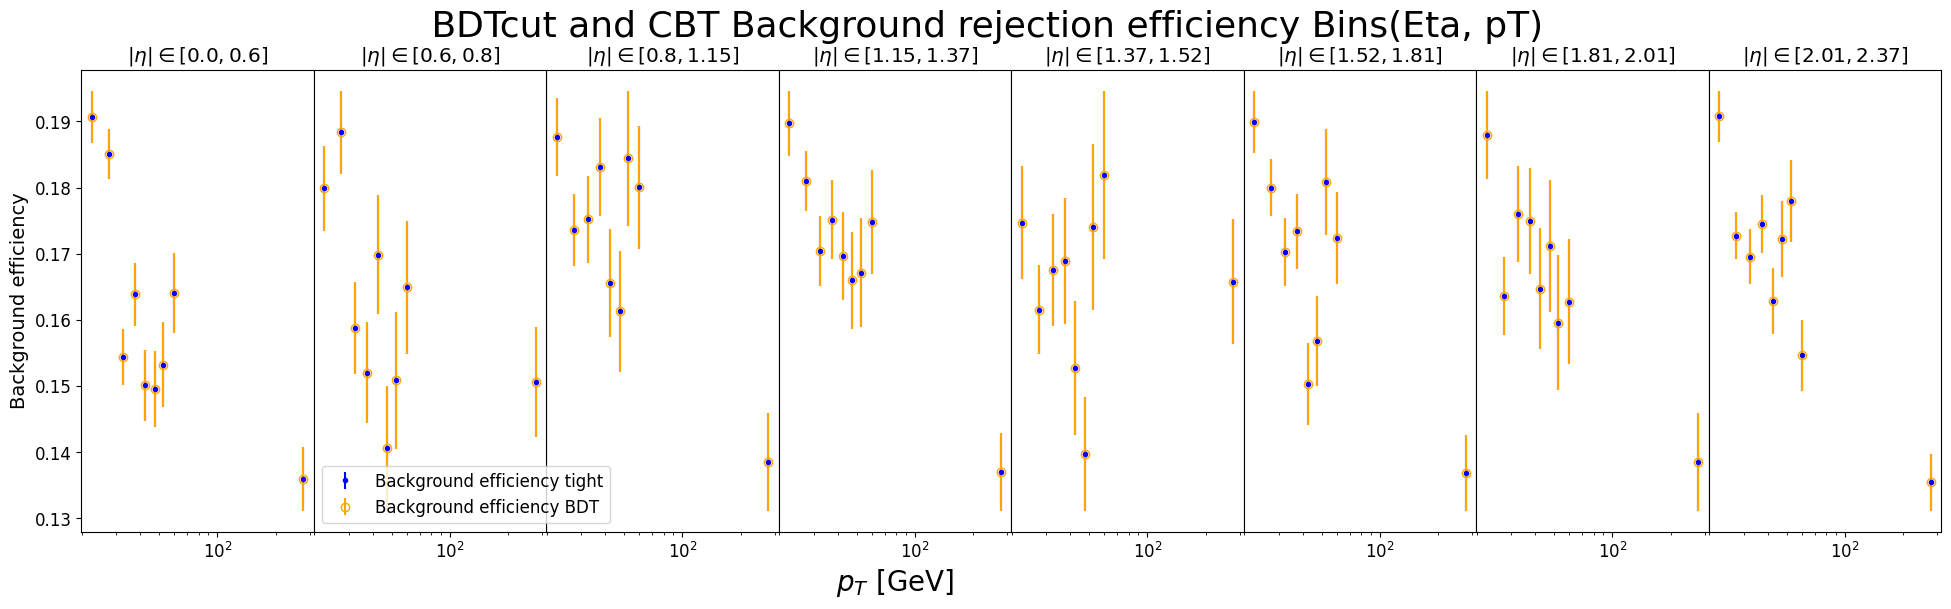

In [29]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_bkg, eff_bkg_tight[i],efferr_bkg_tight[i],
                   fmt=".", label='Background efficiency tight', color = 'blue')
    ax[i].errorbar(pt_bkg, eff_bkg_bdt[i],efferr_bkg_bdt[i],
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    
ax[0].set_ylabel("Background efficiency",  fontsize=14)
ax[3].set_xlabel("$p_{T}$ [GeV]",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)
fig.suptitle(' BDTcut and CBT Background rejection efficiency Bins(Eta, pT)', fontsize=26)

#plt.savefig(savedir+"BDT_PID_rejection.pdf")
plt.show()

In [30]:
len(pt_sig)

41

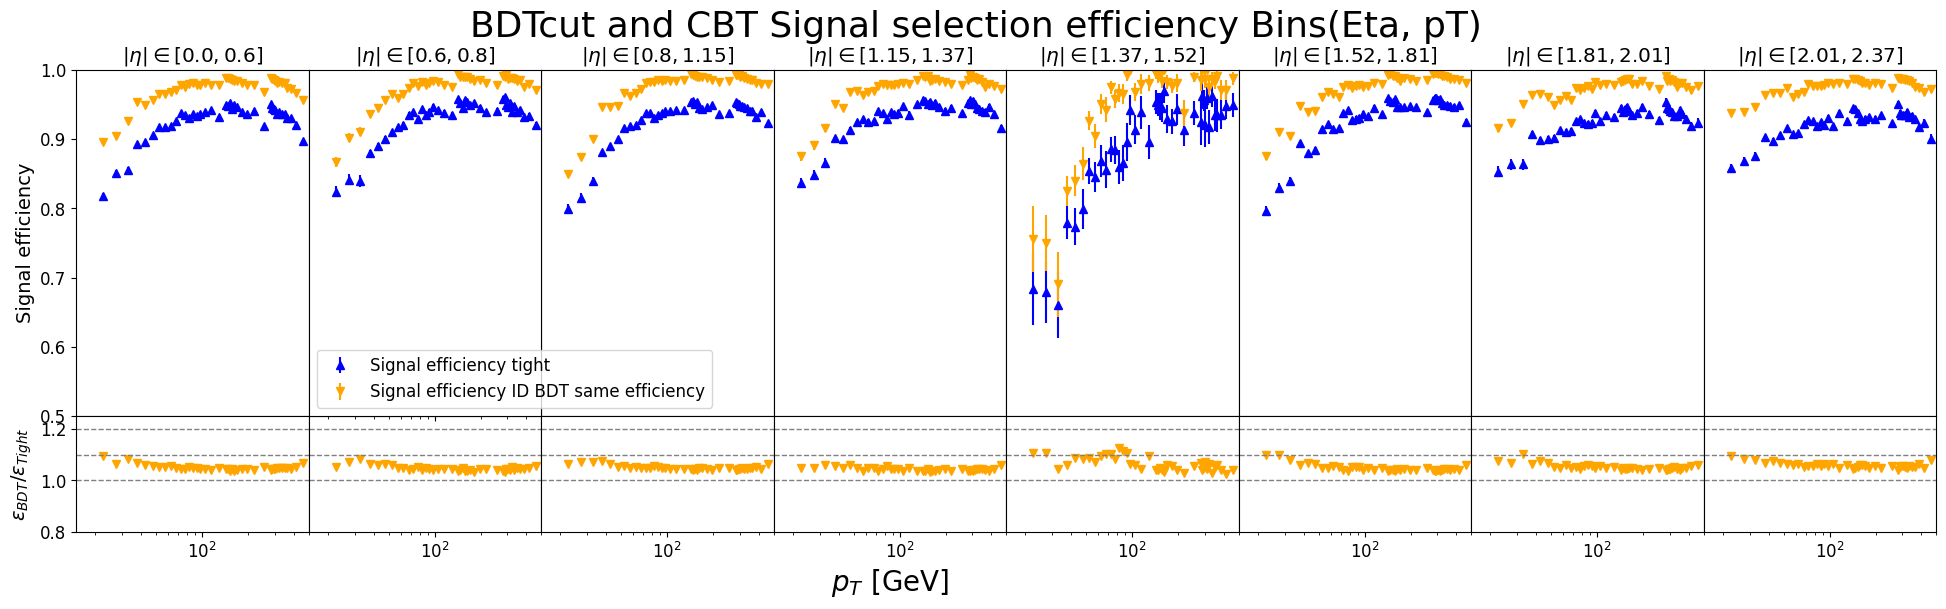

In [31]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_sig, eff_sig_tight[i], efferr_sig_tight[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(pt_sig, eff_sig_bdt[i], efferr_sig_bdt[i],
        fmt="v", label='Signal efficiency ID BDT same efficiency', color = 'orange')    
    ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(pt_sig, eff_sig_bdt[i]/eff_sig_tight[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.2, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([15, 5*10**2])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.5, 1.])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$p_{T}$ [GeV]",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('BDTcut and CBT Signal selection efficiency  Bins(Eta, pT)', fontsize=26)

plt.savefig(savedir+"BDTcut and CBT Signal selection efficiency WP Bins(Eta, pT).pdf")
plt.show()